<div style="background-color: #C19A6B; padding: 10px; border-radius: 5px;">

# 1) Team Title & Information

</div>

### Project Title: **Predicting Customer Churn With Supervised Learning**
### Team Member(s): 
* Ronnie Yalung (VUNetID: yalungr) (CommodoreID: 000859728)

<div style="background-color: #C19A6B; padding: 10px; border-radius: 5px;">

# 2) Introduction

</div>

### Problem Statement:
Customer churn is a challenge for subscription-based businesses. Losing customers directly impacts revenue and growth. This project aims to develop a machine learning model that can accurately predict whether a customer is likely to churn based on their demographic information, service usage, and account details.

### Motivation:
Retaining existing customers is often more cost-effective than acquiring new ones, making churn prediction a high-importance business problem. By identifying customers at risk of leaving, companies can take targeted actions to improve satisfaction and loyalty.

### Objectives:
The goal of this project is to build, evaluate, and compare machine learning models that predict customer churn. We also aim to identify the most influential features contributing to churn, providing valuable insights for business decision-making.

<div style="background-color: #C19A6B; padding: 10px; border-radius: 5px;">

# 3) Data Description & Preprocessing

</div>

In [59]:
# ALL NECESSARY IMPORTS ARE HERE
# DON'T FORGET TO LOAD THIS PART
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import matplotlib.ticker as mtick
warnings.filterwarnings('ignore')

### Data - Source and Description:
The dataset used is titled `customer_churn.csv`, which comes from the course resources on Brightspace. It contains information about customer demographics, account activity, and service usage that can be used to predict customer churn.

Each row represents a unique customer, and the dataset includes the following features:
* Customer ID: unique id for each customer
* Gender: customer's gender ('M' or 'F', categorical)
* Age: Age of the customer (numerical)
* Signup Date: The date which a customer signed up for the platform (datetime value)
* Last Purchase: A datetime timestamp of the customer's most recent purchase (datetime value)
* Total Spent: The total amount of money spent from a particular customer (numerical)
* Payment Method: The type of payment the customer uses (PayPal, credit card) (categorical)
* Subscription Type: The type of subscription a customer uses (Standard, Premium) (categorical)
* Contract Type: The type of contract a customer uses for their account (monthly, yearly, etc.) (categorical)
* Support Call: The number of calls a customer made to reach out to support (numerical)
* Monthly Visits: The average number of platform visits per month (numerical)
* **Churn: target variable — indicates whether the customer has churned (1 = churned, 0 = active); binary value**

In [60]:
# Loading in the dataset...
df = pd.read_csv("customer_churn.csv") # the data we'll be altering
DATA = df.copy() # un-altered data

# Show a few rows
DATA.head()

,Customer_ID,Gender,Age,Signup_Date,Last_Purchase,Total_Spend,Payment_Method,Subscription_Type,Contract,Support_Calls,Monthly_Visits,Churn
0,1.0,M,39.0,2023-07-06 19:48:53.715481,2025-01-24 19:48:53.722594,1421.85,PayPal,NaN,Month-to-Month,0.0,15.7,1.0
1,2.0,M,33.0,2022-07-30 19:48:53.715522,2024-02-11 19:48:53.722602,845.03,Credit Card,Premium,Month-to-Month,3.0,27.8,1.0
2,3.0,F,41.0,2020-10-19 19:48:53.715530,2024-02-16 19:48:53.722608,1483.08,Credit Card,Premium,NaN,4.0,23.2,1.0
3,4.0,F,50.0,2021-03-17 19:48:53.715536,2023-10-19 19:48:53.722614,1904.93,PayPal,Premium,One Year,1.0,18.0,1.0
4,5.0,M,32.0,2020-02-29 19:48:53.715541,2024-09-11 19:48:53.722619,775.05,Credit Card,Standard,Month-to-Month,6.0,7.0,NaN


Before we start our modeling, we need to clean the data by:
* Handle missing values (will need to do this for every column)
* Transform date columns
* Encode categorical variables
* Drop irrelevant columns (like Customer_ID)

| Column              | Type        | Action                                                                 | Why                                                                                   |
|---------------------|-------------|------------------------------------------------------------------------|----------------------------------------------------------------------------------------|
| Customer_ID         | ID          | Drop (not useful for prediction)                                       | It’s just an identifier and carries no predictive value for churn.                    |
| Gender              | Categorical | Convert to binary (e.g., M → 1, F → 0)                                 | ML models can't use strings directly; binary encoding keeps it simple and efficient.  |
| Age                 | Numeric     | Fill missing values with median (if any)                               | Age is a useful predictor; median avoids skew from outliers better than mean.         |
| Signup_Date / Last_Purchase | Datetime    | Convert to datetime | They're techincally in the form of strings, we need to change that. |
| Total_Spend         | Numeric     | Fill missing with median if needed                                     | Total spending is likely tied to churn; imputing ensures we don’t lose useful rows.   |
| Payment_Method      | Categorical | One-hot encode                                                         | Encoding needed to make categorical data usable.                    |
| Subscription_Type   | Categorical | One-hot encode                                                         | Different subscription types can influence churn differently; encoding captures this. |
| Contract            | Categorical | One-hot encode                                                         | Customers with longer contracts are often less likely to churn — needs encoding.      |
| Support_Calls       | Numeric     | Fill missing with 0                                          | High support calls might signal churn risk; missing likely means 0. |
| Monthly_Visits      | Numeric     | Fill missing with median                                               | Lower visits could be linked to disengagement; median helps keep data balanced.       |
| Churn               | Target      | Leave as-is (already binary: 0 or 1)                                   | This is the label we are predicting — already in the correct format. Drop row if NULL; we don't want false positives or negatives|


In [61]:
# Check for missing values
print("\nMissing Values Before Preprocessing:")
print(df.isnull().sum())

# 1) Handle missing values in each column

# Customer_ID - Drop as it's not useful for prediction
df.drop('Customer_ID', axis=1, inplace=True)

# Gender - Convert to binary and handle missing values
# Create mapping dictionary
gender_map = {'M': 1, 'F': 0}
# Apply mapping to non-null values
df['Gender'] = df['Gender'].map(gender_map)
# Fill missing with mode (most common value)
gender_mode = df['Gender'].mode()[0]
df['Gender'] = df['Gender'].fillna(gender_mode)

# Age - Fill missing with median
median_age = df['Age'].median()
df['Age'] = df['Age'].fillna(median_age)

# Signup_Date - Convert to datetime and handle missing values
df['Signup_Date'] = pd.to_datetime(df['Signup_Date'], errors='coerce')
# Fill missing with median date
median_signup = df['Signup_Date'].dropna().median()
df['Signup_Date'] = df['Signup_Date'].fillna(median_signup)

# Last_Purchase - Convert to datetime and handle missing values
df['Last_Purchase'] = pd.to_datetime(df['Last_Purchase'], errors='coerce')
# Fill missing with median date
median_purchase = df['Last_Purchase'].dropna().median()
df['Last_Purchase'] = df['Last_Purchase'].fillna(median_purchase)

# Total_Spend - Fill missing with median
median_spend = df['Total_Spend'].median()
df['Total_Spend'] = df['Total_Spend'].fillna(median_spend)

# Payment_Method - Fill missing values before one-hot encoding
# Get most common payment method
most_common_payment = df['Payment_Method'].mode()[0]
df['Payment_Method'] = df['Payment_Method'].fillna(most_common_payment)

# Subscription_Type - Fill missing values before one-hot encoding
most_common_subscription = df['Subscription_Type'].mode()[0]
df['Subscription_Type'] = df['Subscription_Type'].fillna(most_common_subscription)

# Contract - Fill missing values before one-hot encoding
most_common_contract = df['Contract'].mode()[0]
df['Contract'] = df['Contract'].fillna(most_common_contract)

# Support_Calls - Fill missing with 0 (assuming no calls)
df['Support_Calls'] = df['Support_Calls'].fillna(0)

# Monthly_Visits - Fill missing with median
median_visits = df['Monthly_Visits'].median()
df['Monthly_Visits'] = df['Monthly_Visits'].fillna(median_visits)

# Churn - Our target variable
# Delete missing data; we don't want false positives or negatives
df.dropna(subset=['Churn'], inplace=True)

# 2) Feature engineering and encoding

# Create date-based features
current_date = df['Last_Purchase'].max()
df['Days_Since_Signup'] = (current_date - df['Signup_Date']).dt.days
df['Days_Since_Last_Purchase'] = (current_date - df['Last_Purchase']).dt.days

# One-hot encode Payment_Method
payment_dummies = pd.get_dummies(df['Payment_Method'], prefix='Payment')
df = pd.concat([df, payment_dummies], axis=1)
df.drop('Payment_Method', axis=1, inplace=True)

# One-hot encode Subscription_Type
subscription_dummies = pd.get_dummies(df['Subscription_Type'], prefix='Subscription')
df = pd.concat([df, subscription_dummies], axis=1)
df.drop('Subscription_Type', axis=1, inplace=True)

# One-hot encode Contract
contract_dummies = pd.get_dummies(df['Contract'], prefix='Contract')
df = pd.concat([df, contract_dummies], axis=1)
df.drop('Contract', axis=1, inplace=True)

# 3) Final verification and dataset review

# Check for any remaining missing values (should be none)
print("\nMissing Values After Preprocessing:")
print(df.isnull().sum())

# Display the first few rows of processed data
print("\nProcessed Data Preview:")
print(df.head())


Missing Values Before Preprocessing:
Customer_ID          108
Gender               108
Age                  104
Signup_Date          106
Last_Purchase         99
Total_Spend          101
Payment_Method       106
Subscription_Type    107
Contract             100
Support_Calls         92
Monthly_Visits        96
Churn                 97
dtype: int64

Missing Values After Preprocessing:
Gender                      0
Age                         0
Signup_Date                 0
Last_Purchase               0
Total_Spend                 0
Support_Calls               0
Monthly_Visits              0
Churn                       0
Days_Since_Signup           0
Days_Since_Last_Purchase    0
Payment_Credit Card         0
Payment_Debit Card          0
Payment_PayPal              0
Subscription_Premium        0
Subscription_Standard       0
Contract_Month-to-Month     0
Contract_One Year           0
Contract_Two Year           0
dtype: int64

Processed Data Preview:
   Gender   Age                Sig

### What Exactly Did I Do?

I cleaned the dataset by handling missing values through median/mode imputation or by dropping incomplete rows (specifically for the target variable Churn). I transformed categorical features using one-hot encoding and converted date columns to datetime format. From these dates, I engineered new features (Days_Since_Signup and Days_Since_Last_Purchase) to enrich the dataset with columns that will provide useful information later down the road. Finally, I removed the non-informative Customer_ID column and ensured the dataset was ready for modeling with no remaining nulls.

<div style="background-color: #C19A6B; padding: 10px; border-radius: 5px;">

# 4) Methodology

</div>

### Chosen Machine Learning Algorithms:
This project uses supervised classification models to predict whether a customer will churn. The selected algorithms are:

* Logistic Regression, a linear model that estimates the probability of churn based on a weighted sum of the input features.
* Decision Trees, which create a flowchart-like structure to model decision rules based on feature values.
* Random Forests, an ensemble of multiple decision trees that improve accuracy and robustness by averaging predictions across trees trained on different subsets of the data.

### Model Justification:
These models were selected because they offer a balance between interpretability and predictive power;

* Logistic Regression provides a baseline that helps identify important features.
* Decision Trees are easy to visualize and interpret, making them useful for understanding customer behavior patterns.
* Random Forests typically outperform individual decision trees in accuracy and generalization, making them a strong candidate for the final predictive model.

ALL chosen models are suitable for binary classification tasks like churn prediction and handle structured data well.

### Hyperparameter Tuning:
Hyperparameter tuning will be applied to Decision Trees and Random Forests (to improve model performance).

**For Decision Trees:**
* max_depth: The maximum depth of the tree. Limits how many splits the tree can make. A deeper tree can model complex patterns but may overfit.
* min_samples_split: The minimum number of samples required to split a node. Higher values prevent the model from creating overly specific branches.
* min_samples_leaf: The minimum number of samples required at a leaf node. Helps reduce overfitting by ensuring each final decision is based on enough data.

**For Random Forests:**
* n_estimators: The number of trees in the forest. More trees usually improve performance.
* max_features: The number of features to consider when looking for the best split. Controls diversity among trees in the forest, which can reduce overfitting.
* max_depth: As with decision trees, it limits the depth of each tree to balance learning complexity and generalization.

These hyperparameters will be tuned using Grid Search or Randomized Search with Cross-Validation.

### Baseline Methods:
Logistic Regression will serve as the baseline model for comparison. It provides a simple benchmark to see whether the more complex Decision Tree and Random Forest models offer better performance.

In [62]:
# Step 1: Train/Test Split

# drop the datetime columns as they're not needed for modeling
# (we already created derived features from them)
df = df.drop(['Signup_Date', 'Last_Purchase'], axis=1)

# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

print(f"Dataset shape: {df.shape}")
print(f"Features: {X.columns.tolist()}")
print(f"Churn distribution: {y.value_counts().to_dict()}")

# 1. Train/Test Split (80/20) with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Scale numerical features
numeric_features = ['Age', 'Total_Spend', 'Support_Calls', 'Monthly_Visits', 
                   'Days_Since_Signup', 'Days_Since_Last_Purchase']
scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# 2. Model Training

# a. Logistic Regression
print("\nTraining Logistic Regression Model...")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)
print("Logistic Regression model trained.")

# b. Decision Tree
print("\nTraining Decision Tree Model...")
# Basic model first
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
print("Basic Decision Tree model trained.")

# Hyperparameter tuning for Decision Tree
print("\nPerforming hyperparameter tuning for Decision Tree...")
dt_param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=dt_param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

dt_grid_search.fit(X_train, y_train)
print(f"Best parameters for Decision Tree: {dt_grid_search.best_params_}")

# Get the best model
dt_best_model = dt_grid_search.best_estimator_

# c. Random Forest
print("\nTraining Random Forest Model...")
# Basic model first
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
print("Basic Random Forest model trained.")

# Hyperparameter tuning for Random Forest
print("\nPerforming hyperparameter tuning for Random Forest...")
# Using RandomizedSearchCV for efficiency since the parameter space is larger
rf_param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'max_features': ['sqrt', 'log2', None]
}

rf_random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=rf_param_dist,
    n_iter=12,  # Number of parameter settings sampled
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42
)

rf_random_search.fit(X_train, y_train)
print(f"Best parameters for Random Forest: {rf_random_search.best_params_}")

# Get the best model
rf_best_model = rf_random_search.best_estimator_

print("\nAll models have been trained and tuned.")

Dataset shape: (903, 16)
Features: ['Gender', 'Age', 'Total_Spend', 'Support_Calls', 'Monthly_Visits', 'Days_Since_Signup', 'Days_Since_Last_Purchase', 'Payment_Credit Card', 'Payment_Debit Card', 'Payment_PayPal', 'Subscription_Premium', 'Subscription_Standard', 'Contract_Month-to-Month', 'Contract_One Year', 'Contract_Two Year']
Churn distribution: {1.0: 471, 0.0: 432}
Training set shape: (722, 15)
Testing set shape: (181, 15)

Training Logistic Regression Model...
Logistic Regression model trained.

Training Decision Tree Model...
Basic Decision Tree model trained.

Performing hyperparameter tuning for Decision Tree...
Best parameters for Decision Tree: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}

Training Random Forest Model...
Basic Random Forest model trained.

Performing hyperparameter tuning for Random Forest...
Best parameters for Random Forest: {'n_estimators': 50, 'max_features': 'log2', 'max_depth': 10}

All models have been trained and tuned.


<div style="background-color: #C19A6B; padding: 10px; border-radius: 5px;">

# 5) Results & Evaluation

</div>

### Model Performance Metrics In Use...

This section performs a comprehensive evaluation of multiple machine learning models used for customer churn prediction. It begins by importing the necessary libraries and defining a reusable function to calculate key performance metrics, including accuracy, precision, recall, F1-score, AUC-ROC, and the confusion matrix. Each model is evaluated on the test set, and the results are printed and compiled into a comparison table. Visualizations are then generated to compare ROC curves, display the confusion matrix of the best-performing model, show feature importance rankings for interpretability, and illustrate the distribution of predicted churn probabilities. These steps provide both quantitative and visual insights into how each model performs and what drives their predictions.

Evaluating model performance...

Model: Logistic Regression
Accuracy: 0.6961
Precision (Churn=1.0): 0.7053
Recall (Churn=1.0): 0.7128
F1-Score (Churn=1.0): 0.7090
AUC-ROC: 0.7553
--------------------------------------------------
Model: Decision Tree (Tuned)
Accuracy: 0.5967
Precision (Churn=1.0): 0.5882
Recall (Churn=1.0): 0.7447
F1-Score (Churn=1.0): 0.6573
AUC-ROC: 0.6138
--------------------------------------------------
Model: Random Forest (Tuned)
Accuracy: 0.6906
Precision (Churn=1.0): 0.7159
Recall (Churn=1.0): 0.6702
F1-Score (Churn=1.0): 0.6923
AUC-ROC: 0.7575
--------------------------------------------------

Model Comparison Table:
                   Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC
0    Logistic Regression    0.6961     0.7053  0.7128    0.7090   0.7553
1  Decision Tree (Tuned)    0.5967     0.5882  0.7447    0.6573   0.6138
2  Random Forest (Tuned)    0.6906     0.7159  0.6702    0.6923   0.7575


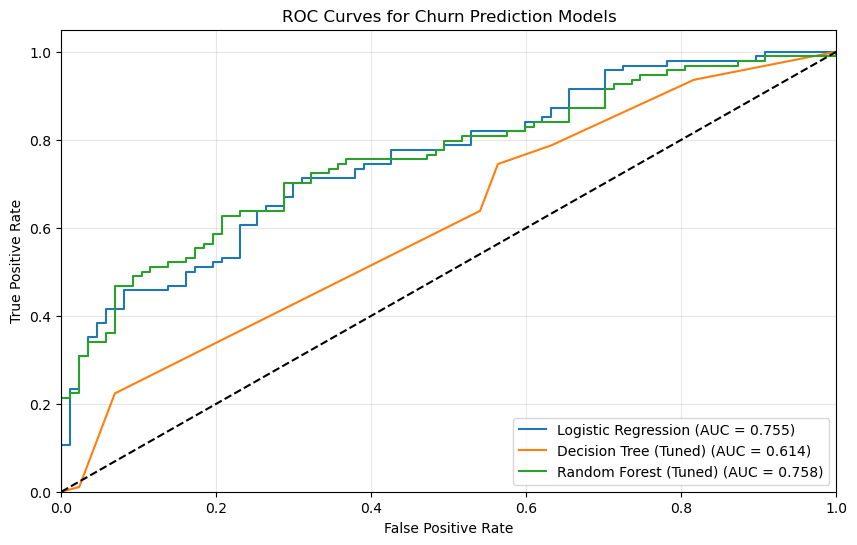

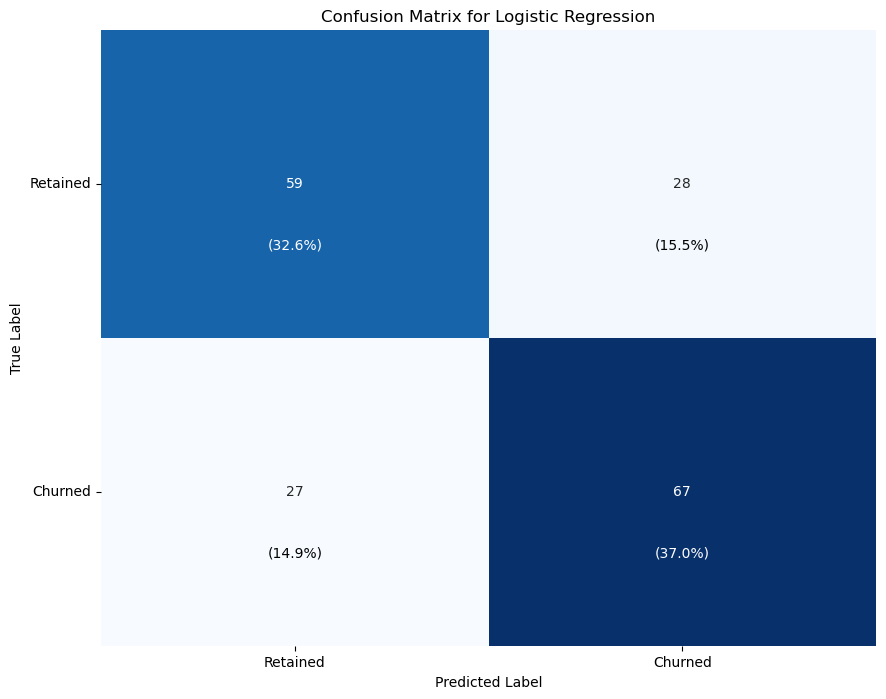

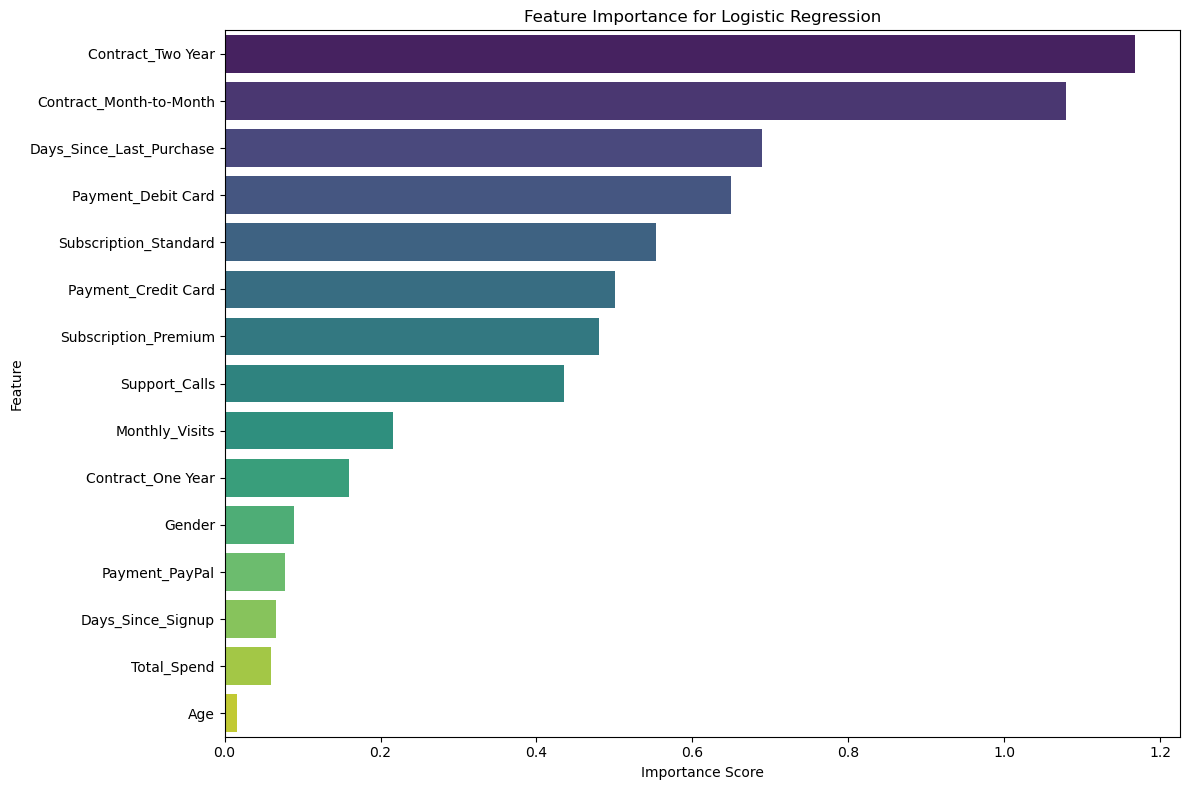


Top 5 Features for Logistic Regression:
                     Feature  Importance
14         Contract_Two Year    1.167162
12   Contract_Month-to-Month    1.079629
6   Days_Since_Last_Purchase    0.689223
8         Payment_Debit Card    0.649586
11     Subscription_Standard    0.552761


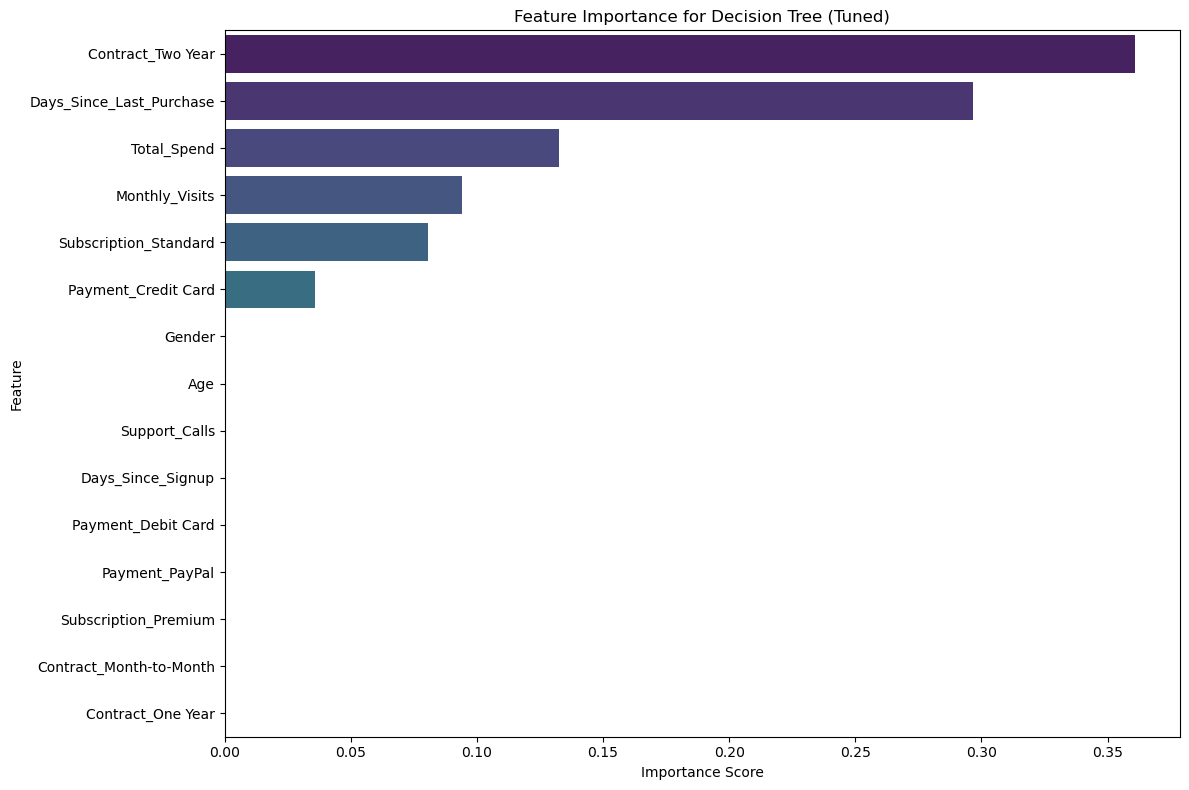


Top 5 Features for Decision Tree (Tuned):
                     Feature  Importance
14         Contract_Two Year    0.360671
6   Days_Since_Last_Purchase    0.296566
2                Total_Spend    0.132574
4             Monthly_Visits    0.094014
11     Subscription_Standard    0.080539


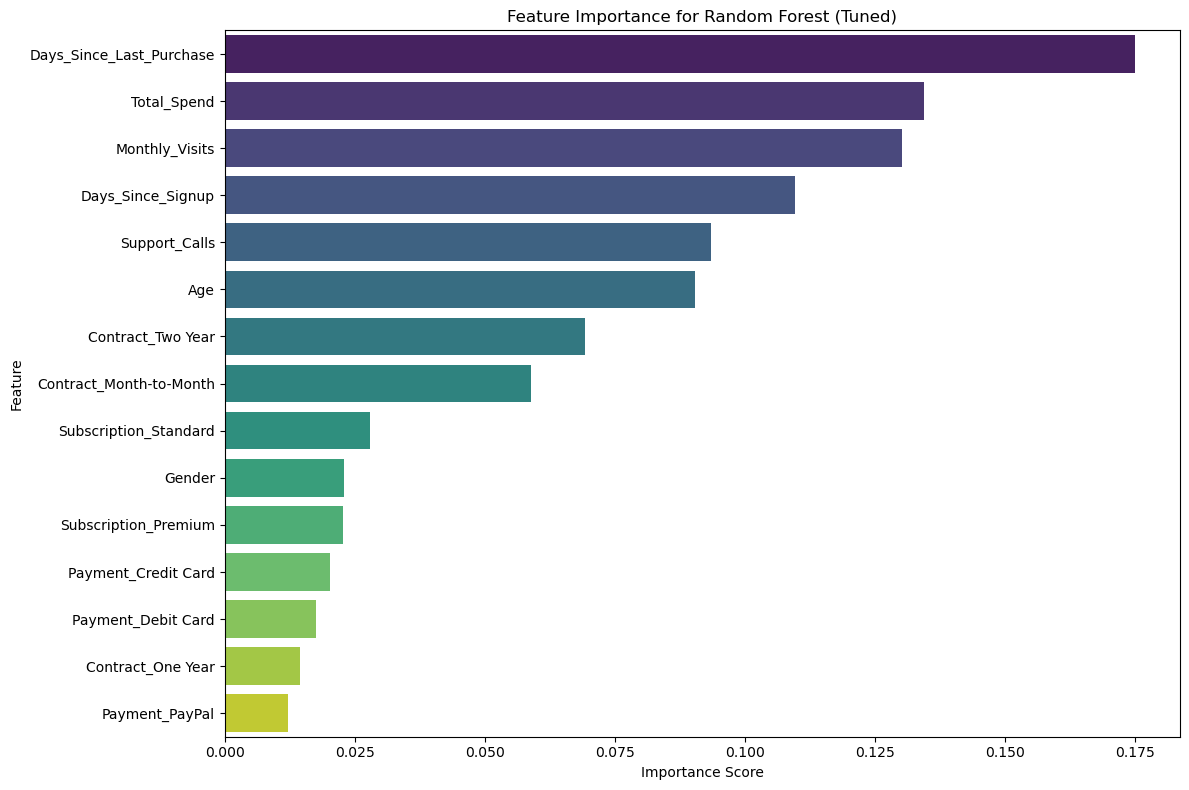


Top 5 Features for Random Forest (Tuned):
                    Feature  Importance
6  Days_Since_Last_Purchase    0.174977
2               Total_Spend    0.134455
4            Monthly_Visits    0.130172
5         Days_Since_Signup    0.109766
3             Support_Calls    0.093595


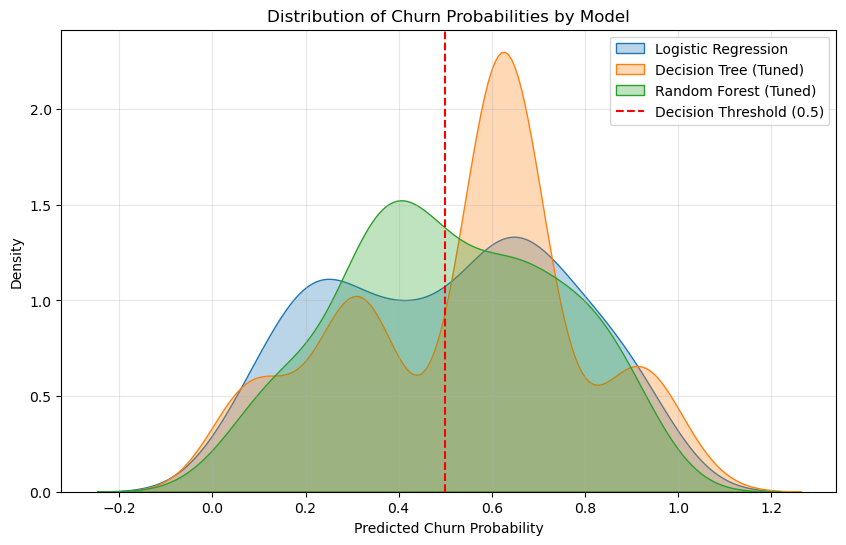

In [71]:
# Model evaluation function
def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model performance and return metrics"""
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # Get the positive class label (may be '1' or 1 depending on data)
    # Find what classes are in the report
    classes = [key for key in report.keys() if key not in ['accuracy', 'macro avg', 'weighted avg']]
    pos_class = classes[-1]  # Usually the last class is positive
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # ROC curve values
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    
    return {
        'name': model_name,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'report': report,
        'pos_class': pos_class,  # Store positive class label
        'confusion_matrix': cm,
        'roc': {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc},
        'pr': {'precision': precision, 'recall': recall}
    }

# 1. Evaluate all models
print("Evaluating model performance...\n")
models = {
    'Logistic Regression': lr_model,
    'Decision Tree (Tuned)': dt_best_model,
    'Random Forest (Tuned)': rf_best_model
}

model_results = {}
for name, model in models.items():
    model_results[name] = evaluate_model(model, X_test, y_test, name)
    pos_class = model_results[name]['pos_class']  # Get positive class label
    
    # Print key metrics
    print(f"Model: {name}")
    print(f"Accuracy: {model_results[name]['report']['accuracy']:.4f}")
    print(f"Precision (Churn={pos_class}): {model_results[name]['report'][pos_class]['precision']:.4f}")
    print(f"Recall (Churn={pos_class}): {model_results[name]['report'][pos_class]['recall']:.4f}")
    print(f"F1-Score (Churn={pos_class}): {model_results[name]['report'][pos_class]['f1-score']:.4f}")
    print(f"AUC-ROC: {model_results[name]['roc']['auc']:.4f}")
    print("-" * 50)

# 2. Create comparison table of model metrics
metrics_df = pd.DataFrame({
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'AUC-ROC': []
})

for name, results in model_results.items():
    pos_class = results['pos_class']  # Get positive class label
    metrics_df = pd.concat([metrics_df, pd.DataFrame({
        'Model': [name],
        'Accuracy': [results['report']['accuracy']],
        'Precision': [results['report'][pos_class]['precision']],
        'Recall': [results['report'][pos_class]['recall']],
        'F1-Score': [results['report'][pos_class]['f1-score']],
        'AUC-ROC': [results['roc']['auc']]
    })], ignore_index=True)

print("\nModel Comparison Table:")
print(metrics_df.round(4))

# 3. Plot ROC curves
plt.figure(figsize=(10, 6))
for name, results in model_results.items():
    plt.plot(
        results['roc']['fpr'], 
        results['roc']['tpr'], 
        label=f"{name} (AUC = {results['roc']['auc']:.3f})"
    )

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Churn Prediction Models')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# 4. Plot confusion matrices
best_model_name = metrics_df.loc[metrics_df['F1-Score'].idxmax(), 'Model']
best_model = models[best_model_name]
best_results = model_results[best_model_name]

plt.figure(figsize=(10, 8))
cm = best_results['confusion_matrix']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

# Calculate percentages for annotations
total = cm.sum()
cm_percent = cm / total * 100

# Add percentage annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j + 0.5, i + 0.7, 
            f'({cm_percent[i, j]:.1f}%)', 
            ha='center', va='center', 
            color='black' if cm[i, j] < cm.max()/2 else 'white'
        )

category_names = ['Retained', 'Churned']
plt.xticks([0.5, 1.5], category_names)
plt.yticks([0.5, 1.5], category_names, rotation=0)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()

# 5. Feature Importance
def plot_feature_importance(model, model_name, feature_names):
    """Plot feature importance for a given model"""
    # Get feature importance based on model type
    if hasattr(model, 'feature_importances_'):
        # For tree-based models
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        # For linear models
        importances = np.abs(model.coef_[0])
    else:
        return None
    
    # Create a dataframe for easier plotting
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.title(f'Feature Importance for {model_name}')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()
    
    return importance_df

# Generate feature importance plots for all models
feature_importance_results = {}
for name, model in models.items():
    importance_df = plot_feature_importance(model, name, X.columns)
    if importance_df is not None:
        feature_importance_results[name] = importance_df
        
        print(f"\nTop 5 Features for {name}:")
        print(importance_df.head(5))

# 6. Churn Probability Distribution
plt.figure(figsize=(10, 6))
for name, results in model_results.items():
    sns.kdeplot(results['y_pred_proba'], label=name, fill=True, alpha=0.3)
    
plt.axvline(x=0.5, color='red', linestyle='--', label='Decision Threshold (0.5)')
plt.title('Distribution of Churn Probabilities by Model')
plt.xlabel('Predicted Churn Probability')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Model Summaries & Comparisons Between Different Models:
**Logistic Regression**
The Logistic Regression model performed well with an accuracy of 69.61% and an F1-score of 0.7090, which shows a good balance between precision and recall. Its recall (0.7128) suggests it's good at identifying customers who actually churned, and its precision (0.7053) shows that most of its churn predictions were correct. The AUC-ROC score of 0.7553 tells us that the model has a good ability to distinguish between churn and non-churn customers across different threshold values. The top predictors for churn included contract type, particularly long-term contracts, and recency of customer activity.

**Decision Tree (Tuned)**
The tuned Decision Tree showed the lowest accuracy at 59.67%, and while it had a decent recall of 0.7447, meaning it captured a high proportion of actual churners, it lacked precision (0.5882), indicating many false positives. The F1-score of 0.6573 is a tell for this imbalance. Additionally, the AUC-ROC score was only 0.6138, telling us there was a weaker discriminative power. Its top predictors for churn included contract type, days since last purchase, and total spend, but the model likely overfitted on certain patterns and didn’t generalize as well as others.

**Random Forest (Tuned)**
The Random Forest model came out with a strong overall performance with a 69.06% accuracy, high precision (0.7159), and a decent recall (0.6702), resulting in an F1-score of 0.6923. It slightly outperformed logistic regression in precision and AUC-ROC (0.7575), indicating that it was better at correctly identifying churners with fewer false positives and had strong classification capability. The top features for the Random Forest were largely based in behavior-like traits, such as days since last purchase, total spend, and monthly visits. This reflected the strength of capturing nonlinear relationships in the data.

**Model Comparison**
When comparing the three models, Logistic Regression and Random Forest were the top players. Logistic Regression slightly beat out Random Forest in recall and F1-score, while Random Forest did slightly better in precision and AUC-ROC. This means Logistic Regression is a bit more aggressive in catching churners, but Random Forest makes more reliable predictions when it does flag churn. Depending on business priorities (e.g., minimizing false positives vs. catching every potential churner), one may be preferred over the other.

The Decision Tree, despite having the highest recall of all three models, lacked because of low accuracy and precision, which would mean a high false positive rate. It might catch more churners, but it does so at the expense of incorrectly flagging many customers who wouldn’t churn. This model’s lower AUC-ROC score also shows us that it’s less effective in separating churn from non-churn cases across thresholds.

Overall, Random Forest offers the best trade-off, especially if the goal is to make reliable churn predictions with fewer false alarms. Logistic Regression is also a strong, interpretable model and may be preferred in scenarios where the model is easier to explain to other people. The Decision Tree model, while easier to understand, didn't perform well and may require further tuning or pruning to be a viable machine learning option in this context.

### Strenghts And Limitations:
**Logistic Regression** demonstrated a solid and consistent performance across all evaluation metrics. One of its biggest strengths is interpretability; the model’s coefficients clearly indicate which features are positively or negatively associated with customer churn. It’s also computationally efficient and less prone to overfitting compared to more complex models. However, logistic regression is limited by its assumption of linearity between features and the log-odds of the outcome. This can make it less effective in capturing complex or nonlinear patterns in the data. Additionally, it often requires more complex and thoughtful feature engineering for optimal performance.

The **Decision Tree** (Tuned) model offers intuitive structure and easy interpretation through its tree-based visualization, which allows analysts to understand the decision-making process step by step. It does well at modeling nonlinear relationships and interactions between features without needing to scale or transform the data. However, despite these facts, it performed the weakest among the three models. It achieved an accuracy of only 59.7%, and while its recall is high at 74.5% (meaning it’s good at identifying churners), its precision and F1-score are relatively low. This suggests that it classifies many non-churners as churners, making its predictions less reliable. Decision trees are also known to be sensitive to slight changes in data and are prone to overfitting unless carefully pruned or tuned, so that may have been why the model didn't perform well.

The **Random Forest** (Tuned) model stood out for its robustness and strong predictive abilities. With an AUC-ROC of 75.8%, the highest among all models, it showed that it had the best ability in distinguishing between churners and non-churners. As an ensemble method, random forest reduces the overfitting risks inherent in single decision trees by averaging across many trees. It handles high-dimensional and complex datasets well and can model intricate relationships between variables. However, this increased power comes at the cost of interpretability; unlike logistic regression or a single decision tree, it’s difficult to explain how a specific prediction was made. It’s also more computationally intensive and can require longer training and tuning times.

### Interpretation of Results: Real-World Implications
The model results suggest that customer churn can be predicted with reasonable accuracy, particularly using Logistic Regression and Random Forest. In practice, this means businesses can identify customers who are at a high risk of leaving and intervene with targeted retention strategies like personalized offers, improved support, or loyalty rewards. The strong influence of features like contract type, time since last purchase, and payment method highlights actionable areas where customer experience improvements could reduce churn. By embedding these models into customer management systems, companies can make decisions that directly impact revenue and customer satisfaction.

<div style="background-color: #C19A6B; padding: 10px; border-radius: 5px;">

# 6) Conclusion & Future Work

</div>

### Key Findings:
The analysis shows that different models offer different advantages, depending on the performance metrics analyzed and prioritized. Logistic Regression provides the most balanced results, showing high performance across accuracy, precision, recall, and F1-score. Its interpretability also makes it ideal for stakeholders who want to understand why customers churn. Random Forest, on the other hand, slightly outperforms Logistic Regression in AUC-ROC, indicating better discriminatory power, which is especially valuable in ranking customers by churn risk. Despite its lower overall metrics, the Decision Tree model demonstrates the highest recall, which means it is the most sensitive in identifying customers who are likely to churn—valuable when the cost of missing a churner is high. Feature importance results also highlight consistent predictors across models, such as “Days Since Last Purchase” and contract type, emphasizing their significance in churn behavior.

### Possible Improvements; Next Steps:
To enhance model performance, future steps could involve deeper hyperparameter tuning, particularly for tree-based models, to improve their generalization and predictive ability. Techniques like cross-validation, grid search, or even Bayesian optimization could have better parameter configurations. Additionally, incorporating more complex models might further improve predictive performance, especially if we can balance interpretability with accuracy. On the data side, enriching the dataset with behavioral or time-series features, such as customer activity trends over time, could help capture churn signals more effectively.

<div style="background-color: #C19A6B; padding: 10px; border-radius: 5px;">

# 7) References

</div>

### Dataset(s):
CS3262 Brightspace Dataset: "customer_churn.csv"

### Other Resources:
* LLM's such as ChatGPT, Claude, and Gemini for code debugging, code commenting, and some explanations
* Google searches for specific python functions (e.g. barplots)
* Youtube Videos for certain topics (e.g. Scikit-Learn, https://youtu.be/0B5eIE_1vpU?si=TZPlzeGTHQ0iwUes)